# **Projeto 3: Redução de Dimensionalidade e Aprendizado Não-Supervisionado**
O projeto consiste em explorar técnicas de redução de dimensionalidade (PCA e Autoencoders) e aprendizado não-supervisionado em técnicas de agrupamento (_clustering_), usando o _dataset_ Fashion-MNIST.

O _dataset_ possui 60000 imagens para treinamento, com outras 10000 para teste. São divididas em 10 classes de roupas.

É recomendado que este código seja executado no COLAB, pois utiliza muita memória em partes específicas. 

In [0]:
from itertools import product
from os.path import exists
from random import sample
from time import process_time
from sys import _getframe

from pandas import read_csv
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Disable Deprecation Warning
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

plt.rcParams['figure.figsize'] = (12,8)

#**Constantes Úteis**

Primeiramente, definimos algumas constantes em relação ao _dataset_ utilizado.

In [0]:
#Dimensions
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

#Classes
N_CLASSES = 10
CLASS_NAMES = {
    0: 't-shirt/top',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle boot',
}

# **Lendo, Observando e Normalizando Dados**

Antes de iniciarmos os experimentos, realizaremos a leitura e normalização dos dados presentes no *dataset* *Fashion-MNIST*.

In [0]:
data = read_csv('fashion-mnist_train.csv')
Y = data['label'].to_numpy()
X = data.drop('label', 1).to_numpy()
classes = list(CLASS_NAMES.values())

### Observando os Dados

Devemos observar o comportamento do _dataset_ antes de começarmos a trabalhar com os dados. Para isso, podemos criar um **histograma** com a quantidade de exemplos para cada classe.

O histograma foi feito para visualizar resultado de modelos, então algumas coisas estarão um pouco fora de contexto nesse uso, mas serve para o propósito desejado.

In [0]:
def histogram(pred, amount=10, model='K-Means'):
    plt.hist(pred, bins='auto')
    plt.title("Amount of images per predicted class for " + model)
    plt.xticks(range(amount))
    #plt.grid()
    plt.show()

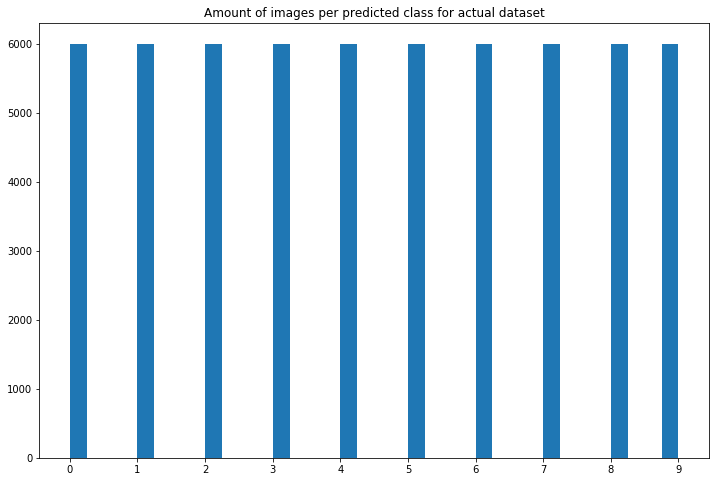

In [96]:
histogram(Y, N_CLASSES, 'actual dataset')

Percebe-se que os exemplos estão divididos igualmente, 6000 por classe.

### Normalizando Dados

Com os dados em memória, podemos **normalizá-los** de diversas maneiras. As estatísticas utilizadas para normalização são as mesmas para todos os conjuntos. Esse processo pode consumir bastante memória então, para economia, sempre que possível os tipos serão alterados.

In [0]:
def get_stats(data, choice=1):
    means,stds,mins,ranges = [],[],[],[]
    
    # Stats for normalization
    if choice == 1 or choice == 3:
        mins = np.apply_along_axis(np.amin, 0, data).astype('int16')
        maxs = np.apply_along_axis(np.amax, 0, data).astype('int16')
        ranges = maxs - mins
    if choice == 2 or choice == 3:
        means = np.apply_along_axis(np.mean, 0, data).astype('float16')
    if choice == 2:
        stds = np.apply_along_axis(np.std, 0, data).astype('float16')
    
    return {'mean':means, 'std':stds, 'mins':mins, 'range':ranges}
    
def normalize_data(data, stats, choice=1):
    ''' Returns the normalized dataset.
    
        Parameters:
            data (array) : numpy array with the dataset.
            stats (array): numpy array with stats given by "get_stats". 0: means. 1: stds. 2:mins. 3:ranges
            choice (int) : integer indicating the transformation to be used.

        Returns:
            data (array list):  transformed data (original data is lost).
    '''

    #### Transforming the dataset ####
    # Min-max normalization
    if choice == 1:
        data = np.apply_along_axis(lambda x: (x - stats['mins'])/stats['range'], 1, data)
            
    # Standardization
    elif choice == 2:
        data = np.apply_along_axis(lambda x: (x - stats['mean'])/stats['std'], 1, data)
            
    # Mean normalization
    elif choice == 3:
        data = np.apply_along_axis(lambda x: (x - stats['mean'])/stats['range'], 1, data)

    return data


Utilizamos o método *standardization*.

In [0]:
# Normalizando Dados
choice = 2
stats = get_stats(X, choice)

In [0]:
X = normalize_data(X, stats, choice).astype('float32')
Y_label = Y
Y = to_categorical(Y).astype('int8')

# **Explorando Redes Neurais**

Como *baseline* do projeto, testaremos algumas redes neurais densas e faremos a comparação entre os resultados obtidos com o *dataset Fashion-MNIST*.

### Treinando Redes

Com o auxílio da biblioteca _Keras_, podemos criar redes neurais densas com facilidade, porém como diversas redes com as mesmas características serão criadas, podemos construir métodos de encapsulamento.

In [0]:
from keras import Model
from keras.models import load_model
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

Serão utilizados Early Stopping para economizar tempo inútil de execução ao detectar convergência, e Model Checkpoint para sempre utilizarmos o que forneceu melhor _loss_ de validação, evitando _overfitting_. Regularização L2 para esse mesmo objetivo.

In [0]:
# Simple neural network, generic
def get_neural_network_model(arc, inp_shape, n_out, activ='relu', optimizer='adam'):
    
    # Input
    inp = Input(shape=inp_shape)
    
    # Hidden Layers
    layer = inp
    for n in arc:
        layer = Dense(n, activation=activ, kernel_regularizer=l2(0.003))(layer)
    
    # Output
    out = Dense(n_out, activation='softmax', kernel_regularizer=l2(0.003))(layer)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Train the neural network
def train(model, X, Y, epochs=50, batch_size=128, val_split=0.1, patience=5, use_calls=True, best=True):
    callbacks = [
                 EarlyStopping(monitor='val_loss', min_delta=0.001, patience=patience),
                 ModelCheckpoint(monitor='val_loss', filepath='best_model.h5', save_best_only=True)
                ]
    
    call = callbacks if use_calls else None
    history = model.fit(x=X, y=Y, epochs=epochs, batch_size=batch_size, validation_split=val_split, callbacks=call).history
    
    if exists('best_model.h5') and best:
        model = load_model('best_model.h5')
    
    return model, history

Para a saída, será utilizada então a função de ativação _softmax_ e, por padrão, ativação ReLU para as camadas escondidas. Também padrão é o utilizador _Adam_, mas esses parâmetros podem ser trocados, assim como a utilização de _callbacks_ e seus parâmetros, e os hiperparâmetros comuns: número limite de épocas, tamanho do _batch_, e tamanho do conjunto de validação, separado pela biblioteca.

Podemos encapsular também essas funções, com uma que cria uma rede e a treina.

In [0]:
def run_network(X, Y, arc, inp_shape, n_out, epochs=50, batch_size=128, val_split=0.1):
    dense = get_neural_network_model(arc, inp_shape, n_out)

    # Train network
    dense.summary()
    dense, hist = train(dense, X, Y, epochs=epochs, batch_size=batch_size, val_split=val_split)
    print('Validation Accuracy: ', np.max(hist['val_acc']))
    
    return hist, dense

As três aquiteturas a serem testadas são:
 1. in, 300, out
 2. in, 470, 100, out
 3. in, 470, 284, 169, 100, 60, 30, out

In [103]:
# Arquiteturas De Redes Densas Para Teste
networks = [[300], [470,100], [470,284,169,100,60,30]]
history = [[],[],[]]

for i,arc in enumerate(networks):
    history[i], _ = run_network(X, Y, 
                                arc, 
                                (IMG_HEIGHT*IMG_WIDTH, ), 
                                N_CLASSES , 
                                epochs=30, 
                                batch_size=1024, 
                                val_split=0.1)

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_130 (Dense)            (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 6s 104us/step - loss: 1.8340 - acc: 0.7874 - val_loss: 1.4524 - val_acc: 0.8523
Epoch 2/30
54000/54000 [==============================] - 1s 18us/step - loss: 1.2274 - acc: 0.8646 - val_loss: 1.0744 - val_acc: 0.8627
Epoch 3/30
54000/54000 [==============================] - 

Obtivemos os seguintes resultados para cada uma das arquiteturas:

ID | Arquitetura | Acurácia Treino | Acurácia Validação
:---: | :---: | :---: | :---:
1 | 784,300,10 | 89,52% | 88,13%
2 | 784,470,100,10 | 90,19% | 88,38%
3 | 784,470,284,169,100,60,30,10 | 91,43% | 88,47%

Apesar das mudanças da arquitetura da rede, as variações na acurácia foram pequenas. Para garantir boa complexidade e velocidade, prosseguiremos com a Arquitetura 2. 

### Analisando Resultados

Podemos observar a convergência da arquitetura a partir de sua história.

In [0]:
def learning_with_history(history):
    ''' 
        Plots learning curves from history (dictionary of lists)
    '''

    keys = sorted(history.keys())
    for k in keys:
        plt.plot(history[k])

    plt.legend(keys, loc='upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Training Metrics')
    plt.show()

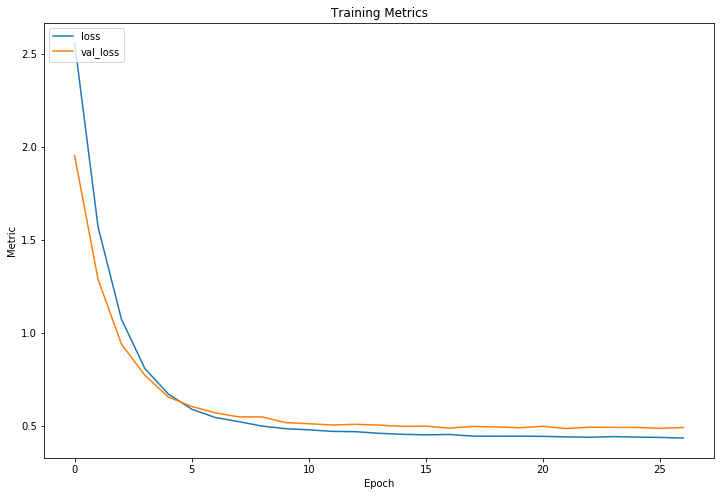

In [105]:
learning_with_history({'loss':history[1]['loss'], 'val_loss':history[1]['val_loss']})

# **Redução de Dimensionalidade**

Em seguida, serão aplicados métodos que visam reduzir o número de *features* presentes no *dataset* fazendo com que este possua menos dimensões tornando-o mais eficiente.
 

### Principal Component Analysis

Primeiramente, aplicaremos o método PCA para analisar quais *features* são pouco representativas do *dataset*, assim podemos realizar a redução de dimensionalidade removendo *features* de forma que seja minizada a informação útil que será perdida. 

Foi utilizada a biblioteca _Scikit-Learn_ para implementação.

In [0]:
from sklearn.decomposition import PCA

In [0]:
def reduce_PCA(X, variance, n_components=0):
    if n_components : pca = PCA(n_components=n_components)
    else : pca = PCA(variance)
    pca.fit(X)
    
    return pca, pca.transform(X)

Serão testadas três "energias", preservando:
 1. 95% de variabilidade
 2. 90% de variabilidade
 2. 85% de variabilidade

In [108]:
# Aplicando Redução Dos Dados Por PCA
variance = [.95, .90, .85]
Xpca = [[],[],[]]
pca = [[],[],[]]
for i,v in enumerate(variance):
  start = process_time()
  pca[i], Xpca[i] = reduce_PCA(X, v)
  print(f'{int(v*100)}% PCA => Reduzido de {X.shape[1]} para {Xpca[i].shape[1]} features ({(process_time()-start):.3}s)')

95% PCA => Reduzido de 784 para 256 features (17.0s)
90% PCA => Reduzido de 784 para 137 features (15.9s)
85% PCA => Reduzido de 784 para 81 features (17.5s)


## Autoencoders

Autoencoders visam a redução de dimensionalidade de forma que, ao invés de descartar a informação, cria-se uma rede para sincretizar a informação original em uma quantia menor de *features*. 

Essa rede minimiza o erro médio quadrático, e é treinada do modo convencional. O componente mais importante é a camada escondida de "**bottleneck**", da qual pode-se extrair os exemplos com menos _features_.

Foram implementados autoencoders **densos** e **convolucionais**, encapsulados de maneira mais genérica.

In [0]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

In [0]:
# Dense autoencoder
def autoencoder(X, arc, inp_shape, activ='relu'):
    
    # Input
    inp = Input(shape=inp_shape)
    
    # Hidden Layers - Encoder
    encoder = inp
    for n in arc:
        encoder = Dense(n, activation=activ)(encoder)
    
    # Hidden Layers - Decoder
    decoder = encoder
    for i in range(len(arc)-1)[::-1]:
        decoder = Dense(arc[i], activation=activ)(decoder)
    
    # Output
    out = Dense(inp_shape[0], activation='sigmoid')(decoder)
    
    # Get models
    autoencoder = Model(inputs=inp, outputs=out)
    encoder = Model(inputs=inp, outputs=encoder)
    autoencoder.compile(loss='mean_squared_error', optimizer='RMSProp')
    
    return autoencoder, encoder

In [0]:
# Convolutional autoencoder
def autoencoder_conv(X, arc, filt_size, pool_size, activ='relu'):
    
    # Input
    inp = Input(shape=(X.shape[1], X.shape[2],1))
    
    # Hidden Layers - Encoder
    encoder = inp
    for n in arc:
        encoder = Conv2D(n, filt_size, activation=activ, padding='same')(encoder)
        encoder = MaxPooling2D(pool_size, padding='same')(encoder)
    
    shape = encoder.get_shape().as_list()
    encoder = Flatten()(encoder)
    
    # Hidden Layers - Decoder
    decoder = Reshape((shape[1],shape[2],shape[3]))(encoder)
    for i in range(len(arc))[::-1]:
        decoder = Conv2D(arc[i], filt_size, activation=activ, padding='same')(decoder)
        decoder = UpSampling2D(pool_size)(decoder)
    
    # Output
    out = Conv2D(1, filt_size, activation='sigmoid', padding='same')(decoder)
    
    # Get models
    autoencoder = Model(inputs=inp, outputs=out)
    encoder = Model(inputs=inp, outputs=encoder)
    autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
    
    return autoencoder, encoder

Para o autoencoder denso, a entrada é a mesma que as redes testadas, como lido do arquivo e normalizado. Já para o convolucional, é preciso colocar os dados em formato de imagem tridimensional (como são monocromáticas, a profundidade é 1).

Serão testadas três arquiteturas de autoencoders densos:
  1. in, 255
  2. in, 128, 64, 32
  3. in, 255, 136, 20 

In [112]:
# Aplicando Redução Dos Dados Com Autoencoders
encoders = [[255], [128,64,32], [255,136,20]]
Xenc = [[], [], []]
for i,arc_enc in enumerate(encoders):
    start = process_time()
    autoenc, enc = autoencoder(X, arc_enc, (IMG_HEIGHT*IMG_WIDTH, ))
    autoenc.summary()
    autoenc, _ = train(autoenc, X, X, epochs=50, batch_size=1024, val_split=0, use_calls=False, best=False)
    Xenc[i] = enc.predict(X)
    print(f"{arc_enc} Arq. => Reduzido de {X.shape[1]} para {Xenc[i].shape[1]} features ({(process_time()-start):.5}s)")

Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_141 (Dense)            (None, 255)               200175    
_________________________________________________________________
dense_142 (Dense)            (None, 784)               200704    
Total params: 400,879
Trainable params: 400,879
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.7304
Epoch 2/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.6362
Epoch 3/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.6182
Epoch 4/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.6090
Epoch 5/50
60000/60000 [==============

Será testada apenas uma arquitetura de autoencoder convolucional:

- Input
- 16 filtros 3x3
- Max Pooling 2x2
- 8 filtros 3x3
- Max Pooling 2x2

A saída do encoder é a representação _flattened_ do resultado, que depois no decoder retorna ao formato de imagem e ao tamanho original.

In [113]:
c_encoders = [[16,8]]
Xconv = []
Ximg = X.reshape((X.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
for i,arc_enc in enumerate(c_encoders):
    # Convolutional Auto-Encoder
    start = process_time()
    autoenc, enc = autoencoder_conv(Ximg, arc_enc, (3,3), (2,2))
    autoenc.summary()
    autoenc, _ = train(autoenc, Ximg, Ximg, epochs=50, batch_size=1024, val_split=0, use_calls=False, best=False)
    Xconv.append(enc.predict(Ximg))
    print(f"{arc_enc} Arq. => Reduzido de {X.shape[1]} para {Xconv[i].shape[1]} features ({(process_time()-start):.5}s)")

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 392)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 8)           0  

### Testando Reduções

Treinaremos a rede escolhida na etapa anterior com as dimensões (*features*) originais reduzidas por ambos os métodos apresentados. Por fim, analisaremos os resutlados obtidos e escolheremos o método de redução mais eficiente. 

In [114]:
# Arquiteturas De Redes Densas Para Teste
arc = [470,100]

# Re-treinando a rede com as entradas reduzidas por PCA
for v,x in zip(variance, Xpca):
    run_network(x, Y,
                arc, 
                (x.shape[1], ), 
                N_CLASSES , 
                epochs=30, 
                batch_size=1024, 
                val_split=0.1)
    print(f"Arq. {arc} com PCA de {int(v*100)}%")
    print("======================================================")

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 470)               120790    
_________________________________________________________________
dense_156 (Dense)            (None, 100)               47100     
_________________________________________________________________
dense_157 (Dense)            (None, 10)                1010      
Total params: 168,900
Trainable params: 168,900
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 6s 111us/step - loss: 1.8967 - acc: 0.7818 - val_loss: 1.3696 - val_acc: 0.8592
Epoch 2/30
54000/54000 [==============================] - 1s 16

In [115]:
# Re-treinando a rede com as entradas reduzidas por Autoencoders Densos
for e,x in zip(encoders, Xenc):
  run_network(x, Y, 
              arc, 
              (x.shape[1], ), 
              N_CLASSES, 
              epochs=30, 
              batch_size=1024, 
              val_split=0.1)
  print(f"Arq. {arc} com Encoder Tipo {e}")
  print("======================================================")

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 255)               0         
_________________________________________________________________
dense_164 (Dense)            (None, 470)               120320    
_________________________________________________________________
dense_165 (Dense)            (None, 100)               47100     
_________________________________________________________________
dense_166 (Dense)            (None, 10)                1010      
Total params: 168,430
Trainable params: 168,430
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 7s 122us/step - loss: 2.2689 - acc: 0.7424 - val_loss: 1.8313 - val_acc: 0.8318
Epoch 2/30
54000/54000 [==============================] - 1s 17

In [116]:
# Re-treinando a rede com as entradas reduzidas por Autoencoders Convolucionais
for e,x in zip(c_encoders, Xconv):
  run_network(x, Y, 
              arc, 
              (x.shape[1], ), 
              N_CLASSES , 
              epochs=30, 
              batch_size=1024, 
              val_split=0.1)
  print(f"Arq. {arc} com Encoder Tipo {e}")
  print("======================================================")

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 392)               0         
_________________________________________________________________
dense_173 (Dense)            (None, 470)               184710    
_________________________________________________________________
dense_174 (Dense)            (None, 100)               47100     
_________________________________________________________________
dense_175 (Dense)            (None, 10)                1010      
Total params: 232,820
Trainable params: 232,820
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 7s 133us/step - loss: 2.3650 - acc: 0.7563 - val_loss: 1.9359 - val_acc: 0.8348
Epoch 2/30
54000/54000 [==============================] - 1s 20

Dadas as reduções realizadas, os seguintes resultados para os *autoencoders* e PCAs utilizados:

**Resultados:**
  
 Arquitetura | PCA Treino | PCA Validação | Encoder Treino | Encoder Validação
 :---: | :---: | :---: | :---: | :---:
1 | 90,29% | 88,80% | 91,24% | 88,83%
2 | 89,88% | 88,50% | 86,84% | 86,23%
3 | 88,87% | 88,06% | 87,54% | 86,43%

*Convolucional:* treino - 88,83% & validação - 87,98%

Observa-se que o PCA é relativamente rápido de ser executado (cerca de 14s) e apresenta resultados tão bons ou melhores que os *autoencoders*, estes em contrapartida levam mais tempo para serem treinados. Portanto, decidimos proceder com a redução pro PCA com variância de 95%.

### Teste Com Arquitetura Baseline

Com a arquitetura final e o melhor dos métodos de redução de dimensionalidade, podemos comparar o resultado original com o obtido utilizando as _features_ reduzidas.

In [0]:
arc = [470,100]

In [118]:
# Running original baseline
start = process_time()
run_network(X, Y, 
            arc, 
            (IMG_HEIGHT*IMG_WIDTH, ), 
            N_CLASSES , 
            epochs=50, 
            batch_size=1024, 
            val_split=0.1)
print(f"Runtime: {(process_time()-start):.5}s")

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 470)               368950    
_________________________________________________________________
dense_177 (Dense)            (None, 100)               47100     
_________________________________________________________________
dense_178 (Dense)            (None, 10)                1010      
Total params: 417,060
Trainable params: 417,060
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 8s 147us/step - loss: 2.5348 - acc: 0.7953 - val_loss: 1.9117 - val_acc: 0.8598
Epoch 2/50
54000/54000 [==============================] - 2s 29

In [119]:
# Running same architecture, but with PCA 95%
start = process_time()
history, model = run_network(Xpca[0], Y, 
                             arc, 
                             (Xpca[0].shape[1], ), 
                             N_CLASSES , 
                             epochs=50, 
                             batch_size=1024, 
                             val_split=0.1)
print(f"Runtime: {(process_time()-start):.5}s")

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 470)               120790    
_________________________________________________________________
dense_180 (Dense)            (None, 100)               47100     
_________________________________________________________________
dense_181 (Dense)            (None, 10)                1010      
Total params: 168,900
Trainable params: 168,900
Non-trainable params: 0
_________________________________________________________________
Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 7s 136us/step - loss: 1.9015 - acc: 0.7798 - val_loss: 1.3581 - val_acc: 0.8557
Epoch 2/50
54000/54000 [==============================] - 1s 17

Podemos também conferir a convergência dessa última rede.

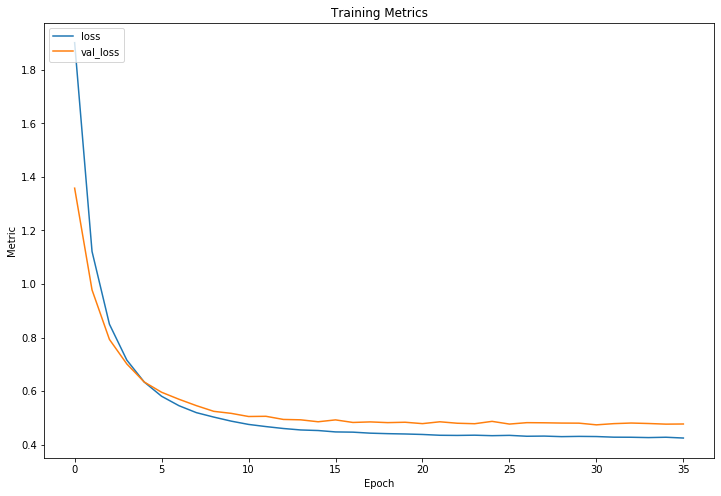

In [120]:
learning_with_history({'loss':history['loss'], 'val_loss':history['val_loss']})

E, por último, podemos utilizar o conjunto de **teste** para avaliar a qualidade final da rede escolhida. 

In [0]:
# Reading test set.
data = read_csv('fashion-mnist_test.csv')
Y_test = data['label'].to_numpy()
X_test = data.drop('label', 1).to_numpy()

# Normalizing test set
X_test = normalize_data(X_test, stats, choice).astype('float32')
Y_tlabel = Y_test
Y_test = to_categorical(Y_test).astype('int8')

In [0]:
# Reducing using same PCA model.
X_tpca = pca[0].transform(X_test)

Para testar, podemos utilizar a **matriz de confusão**, e com ela é possível calcular métricas como acurácia, precisão por classe, revocação por classe, e F1 Score por classe.


In [0]:
# Confusion matrix for the results.
def confusion_matrix(Y, Y_pred, classes):
    conf = np.zeros((classes,classes)).astype('int32')
    for i in range(Y.size):
        conf[Y[i], Y_pred[i]] += 1
    return conf

# Accuracy from confusion matrix. True/total
def accuracy(confusion):
    true_amount = confusion.trace()
    total = confusion.sum()
    return true_amount/total
    
# Precision per class from confusion matrix.
def precision(confusion):
    diag = np.diagonal(confusion)
    return diag/confusion.sum(0)

# Recall per class from confusion matrix.
def recall(confusion):
    diag = np.diagonal(confusion)
    return diag/confusion.sum(1)

# F1 Score per class from precision and recall
def f1_score(prec, rec, bound=1e-8):
    return 2*prec*rec/(prec+rec+bound)
    

# Function to calculate metrics for evaluation
def get_metrics(target, predictions, classes):
    conf = confusion_matrix(target, predictions, classes)
    
    # Metrics
    acc = accuracy(conf)
    prec= precision(conf)
    rec = recall(conf)
    f1 = f1_score(prec, rec)
    avg_acc = (prec + rec)/2
    
    return {'accuracy':acc, 'norm_acc':avg_acc, 'precision':prec, 'recall':rec, 'f1':f1}, conf

In [0]:
# Predicting and testing test set.
pred = model.predict(X_tpca)
pred_label = pred.argmax(axis=-1)
metrics, CM = get_metrics(Y_tlabel, pred_label, N_CLASSES)

In [125]:
print('Accuracy:', metrics['accuracy'])
print('Normalized Accuracy:', metrics['norm_acc'])
print('Precision (per class):', metrics['precision'])
print('Recall (per class):', metrics['recall'])
print('F1 Score (per class):', metrics['f1'])

Accuracy: 0.8935
Normalized Accuracy: [0.83562133 0.98343414 0.83355372 0.91138123 0.85488417 0.94806027
 0.73460978 0.92130905 0.96969585 0.9401068 ]
Precision (per class): [0.84024267 0.98986829 0.84710744 0.89176245 0.83976834 0.95812053
 0.74921956 0.92361809 0.96439169 0.92621359]
Recall (per class): [0.831 0.977 0.82  0.931 0.87  0.938 0.72  0.919 0.975 0.954]
F1 Score (per class): [0.83559577 0.98339204 0.83333333 0.9109589  0.85461689 0.94795351
 0.73431922 0.92130325 0.96966683 0.93990147]


A matriz de confusão pode ser visualizada a seguir.


In [0]:
def plot_confusion_matrix(confusion, classes, model):
    '''
        Plots an already created confusion matrix for a generic amount of classes.
    '''
    
    fig, ax = plt.subplots(1)

    #Bounding box
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    plt.title('Confusion Matrix for ' + model)

    #Ticks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thr = confusion.max()/2
    for i, j in product(range(confusion.shape[0]), range(confusion.shape[1])):
        plt.text(j, i, confusion[i, j],
            horizontalalignment='center',
            color='white' if confusion[i, j] > thr else 'black')

    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.imshow(confusion, interpolation='nearest', cmap='Blues')
    plt.show()

    return fig, ax

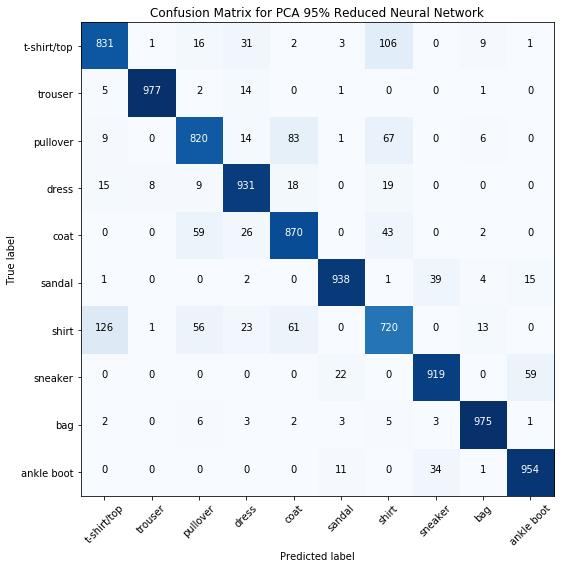

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f838f4128>)

In [127]:
plot_confusion_matrix(CM, classes, 'PCA 95% Reduced Neural Network')

# **Clustering**

Utilizando o melhor resultado para as aquiteturas e reduções testadas, buscamos aplicar dois métodos de clustering para a arquitetura 2 com PCA (95% de variância preservada).
Os métodos escolhidos foram o **K-Means** e o **Agglomerative Clustering** (clustering hierárquico).

### Preprocessamento

Utilizaremos PCA com 95% de variância, então devemos separar esse conjunto.

In [0]:
Xcl = Xpca[0]

Para compreender melhor o *dataset*, também confeccionamos um *scatter plot* a partir da redução por PCA para apenas duas componentes. A fim de saber o quão útil é está visualização para nossa análise, também exibimos a variabilidade preservada pelas duas componentes restantes.

In [0]:
def pca_plotting(X, clust, classes, s=4):
    bidim = PCA(n_components=2)
    Xpca = bidim.fit_transform(X)
    print(f"Preserved Variance {sum(bidim.explained_variance_ratio_)*100:.4}%")

    for c,l in enumerate(classes):
        plt.scatter(Xpca[clust==c,0], Xpca[clust==c,1], label=l, s=s)
    
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    plt.legend()
    plt.show()

Preserved Variance 36.45%


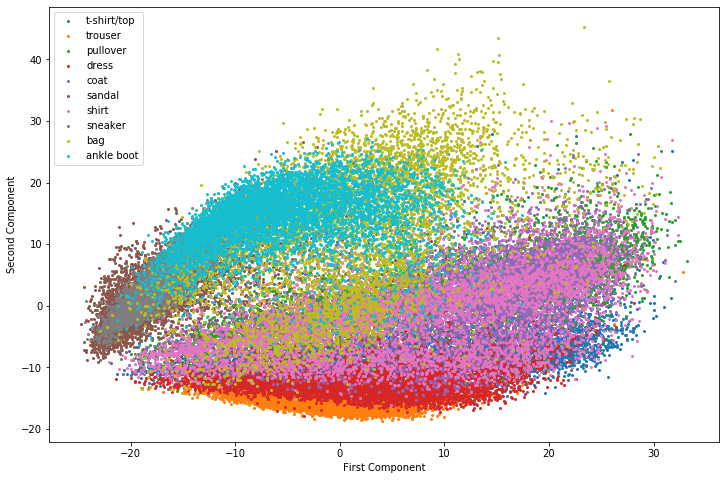

In [130]:
pca_plotting(X, Y_label, classes)

Com isso, utilizamos os métodos de _clustering_ implementados na biblioteca _Scikit-Learn_.

In [0]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [0]:
def k_means(X, n_clusters, init='k-means++', max_iter=300, tolerance=1e-4):
    km = KMeans(n_clusters, init, max_iter=max_iter, tol=tolerance)
    km.fit(X)
    return km, km.predict(X)

# Can train with at most 30k samples with a PCA of .95 
def agglomerate(X, n_clusters, linkage='ward'):
    aggclust = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(X)
    return aggclust, aggclust.labels_

### Testando Clusters

Para todos esses métodos, para testar seus resultados precisamos primeiro converter os _clusters_ em predições de classe.

In [0]:
def label_clusters(n_classes, Y_true, clusters):
    '''Binds each of the clusters labels to a class label creating a prediction array
    
        Parameters:
            n_classes (int): Amount of classes/clusters in the dataset/model
            clusters (array of int): cluster associated to each sample (sample i binds to cluster x[i])
            Y_true (array of int): class associated to each sample (sample i belongs to class x[i])

        Returns:
            Y_pred (array of int): contains the predicted class of sample i which is binded to the cluster clusters[i]
    '''

    # Create true_labelXcluster_label frequency matrix
    count = np.zeros((n_classes, n_classes), dtype=int)
    for i in range(n_classes):
        for j in clusters[Y_true==i]:
            count[i,j] += 1

    # Assing a label (class) for each cluster
    Y_pred = np.zeros(len(clusters), dtype=int)
    while (True):
        x = count.argmax()
        i = x//n_classes
        j = x%n_classes
        if count[i,j] < 0 : break
        count[i,:] = count[:,j] = -1
        Y_pred[clusters==j] = i

    return Y_pred

Precisamos também de métodos para testar essas técnicas. Existem diversas disponíveis, porém quando temos os dados anotados outras técnicas melhores ficam disponíveis também.

A biblioteca Scikit-Learn possui alguns desses métodos, mas podemos implementar alguns próprios também.

In [0]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, v_measure_score, silhouette_score

In [0]:
def test_clusters(clusters, Y, n_classes, X):
    
    # Get predictions
    pred = label_clusters(n_classes, Y, clusters)
    
    # Supervised Scores
    rand = adjusted_rand_score(pred, Y)
    mutual = adjusted_mutual_info_score(pred, Y)
    vscore = v_measure_score(Y, pred)
    metrics, CM = get_metrics(Y, pred, n_classes)
    
    # Unsupervised Score
    unsup = silhouette_score(X, clusters, metric='euclidean')
    
    return {'rand':rand, 'mutual':mutual, 'vscore':vscore, 'silhouette':unsup, 'acc':metrics['accuracy']}, CM


Então temos diversas maneiras de medir o sucesso do agrupamento, sejam supervisionadas e não-supervisionadas. Das métricas obtidas a partir da matriz de confusão, foi escolhida apenas a acurácia por ser um único valor, com os outros dependendo da classe.

### **K-Means**

In [0]:
# Executing K-Means clustering
model, clusters = k_means(Xcl, N_CLASSES, 'k-means++', 1000, 1e-4)

Inicialmente, podemos utilizar o histograma para ver a distribuição dos exemplos entre as classes, e comparar com a divisão original vista anteriormente. Isso pode ser feito com o K-Means pois estamos utilizando todos os exemplos.

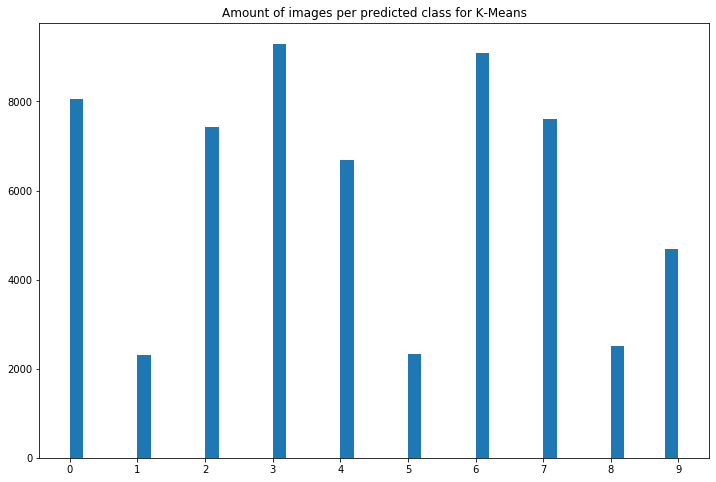

In [137]:
# Testing K-Means: Histogram
histogram(clusters, 10, 'K-Means')

In [138]:
# Testing K-Means: Metrics
dic, CM = test_clusters(clusters, Y_label, N_CLASSES, Xcl)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [139]:
print('Adjusted Rand Score:', dic['rand'])
print('Adjusted Mutual Score:', dic['mutual'])
print('V-Measure Score:', dic['vscore'])
print('Accuracy:', dic['acc'])
print('Silhouette Score:', dic['silhouette'])

Adjusted Rand Score: 0.34977930102091076
Adjusted Mutual Score: 0.4945412055962169
V-Measure Score: 0.5067305715280243
Accuracy: 0.48485
Silhouette Score: 0.13741627


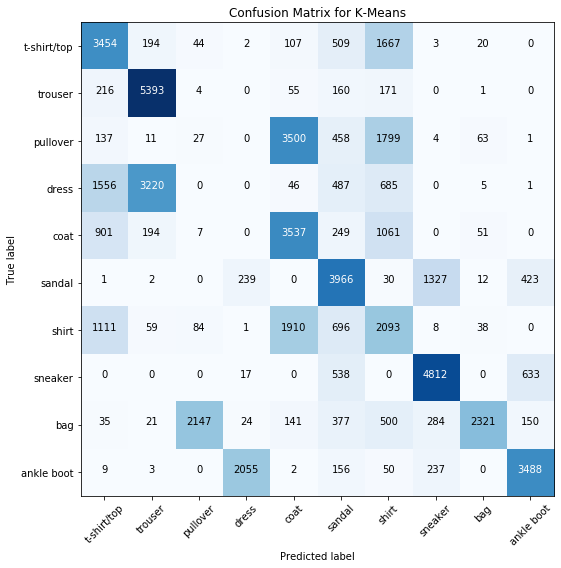

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f83669978>)

In [140]:
# Testing K-Means: Confusion Matrix
plot_confusion_matrix(CM, classes, 'K-Means')

### **Agglomerative Clustering**

Como esse método utiliza muita memória, talvez não seja adequado utilizar todos os exemplos. Então devemos separar uma fração dos exemplos.

Para conseguir utilizar todos os exemplos no *Agglomerative Clustering*, é necessária uma grande quantidadede memória disponível. Recomenda-se utilizar o COLAB, mas ainda assim é possível que não consiga utilizar tudo.

In [0]:
amount = 40000

samp = sample(range(60000), amount)
Xagg = Xcl[samp]
Yagg = Y_label[samp]

In [0]:
# Execute Agglomerative Clustering
model, clusters = agglomerate(Xagg, N_CLASSES, linkage='ward')

Nesse caso, não utilizaremos o histograma, pois não é possível agrupar todos os exemplos simultaneamente.

In [143]:
# Testing Agglomerate: Metrics
dic, CM = test_clusters(clusters, Yagg, N_CLASSES, Xagg)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [144]:
print('Adjusted Rand Score:', dic['rand'])
print('Adjusted Mutual Score:', dic['mutual'])
print('V-Measure Score:', dic['vscore'])
print('Accuracy:', dic['acc'])
print('Silhouette Score:', dic['silhouette'])

Adjusted Rand Score: 0.36117915867442313
Adjusted Mutual Score: 0.5543758887593603
V-Measure Score: 0.5756106922339502
Accuracy: 0.478
Silhouette Score: 0.1222905


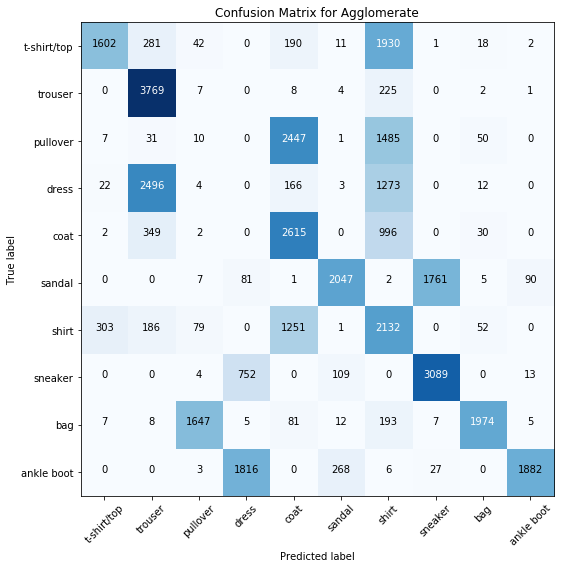

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7f87b17048>)

In [145]:
# Testing K-Means: Confusion Matrix
plot_confusion_matrix(CM, classes, 'Agglomerate')